In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
plt.set_loglevel(level = 'warning')
import os

# Load Model Predictions

In [2]:
base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal/N=500,D=2500,D_eval=1000,cnts1=25,cnts2=25,forced/models/'
bd_flex = base_dir+'/0426_bimodal_forced_sequential_2'
bd_bb = base_dir+'/0426_bimodal_sequential_bb_ab_2'
model_paths = {
    'PS AutoReg Neural Net': f'{bd_flex}/sequential:epochs=1000,bs=500,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=50,weight_factor=1,max_obs=500,repeat_suffstat=10,Zdim=2,sched=constant,seed=2340923/',
    'PS AutoReg Beta-Bernoulli': f'{bd_bb}/sequential:epochs=1000,bs=500,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=50,weight_factor=1,max_obs=500,repeat_suffstat=1,Zdim=2,sched=constant,BB=True,alphabeta=True,seed=2340923/',
}

In [3]:
prediction_dicts = {}
for name, run_dir in model_paths.items():
    preds = torch.load(run_dir + '/best_loss_predictions.pt')
    prediction_dicts[name] = preds

prediction_dicts.keys()

dict_keys(['PS AutoReg Neural Net', 'PS AutoReg Beta-Bernoulli'])

In [4]:
from closed_form_models import BetaBernoulli, BetaBernoulliMixture

In [5]:
new_prediction_dicts = {}

In [6]:
dataset = 'val'

In [7]:
# BETA BERNOULLI MODELS =====================================================================================

all_BB_models = {}

# Standard beta comparison =============================
prior_means_eval = preds[dataset]['theta_hats']
true_means_train = preds['train']['click_rates']
prior_dict = {
                "alpha": prior_means_eval[:,0]*0+1,
                "beta": prior_means_eval[:,0]*0+1,
                }
bb_model_eval_marginal = BetaBernoulli(prior_dict)
obs_seq_eval = preds[dataset]['click_obs']
post_alpha, post_beta = bb_model_eval_marginal.compute_posterior_seq(obs_seq_eval)
post_means, post_vars = bb_model_eval_marginal.compute_post_mean_var(post_alpha, post_beta)

new_prediction_dicts[f"Beta-Bernoulli (Uniform Prior)"] = { dataset : { "theta_hats": post_means,
                                                        "click_rates": preds[dataset]['click_rates'].squeeze(),
                                                                       "click_obs": obs_seq_eval
                                                                        } }
all_BB_models['Uniform Prior'] = bb_model_eval_marginal


# Oracle beta mixture comparison =============================
key = list(model_paths.keys())[0] 
Zvec = prediction_dicts[key][dataset]['Z']
cnts1 = 25; cnts2 = 25

mean1 = Zvec[:,0]*0.25; mean2 = 0.75+Zvec[:,1]*0.25
alpha1 = mean1*cnts1 + 1; beta1 = 2 + cnts1 - alpha1
alpha2 = mean2*cnts2 + 1; beta2 = 2 + cnts2 - alpha2

prior_dict = {
                "alpha1": alpha1,
                "beta1": beta1,
                "alpha2": alpha2,
                "beta2": beta2,
                "mixweight": 0.5,
                }
bb_model_oracle = BetaBernoulliMixture(prior_dict)
obs_seq_eval = preds[dataset]['click_obs']
post_dict = bb_model_oracle.compute_posterior_seq(obs_seq_eval)

post_means = bb_model_oracle.compute_post_mean(post_dict)

new_prediction_dicts[f"Oracle (True DGP)"] = { dataset : { "theta_hats": post_means,
                                                           "click_rates": preds[dataset]['click_rates'].squeeze(),
                                                            "click_obs": obs_seq_eval,
                                                                        } }
all_BB_models['Oracle (True DGP)'] = bb_model_oracle

all_prediction_dicts = {**prediction_dicts, **new_prediction_dicts}

In [8]:
# Process the prediction dictionaries
model2predictions = {}
for name, pred_dict in all_prediction_dicts.items():
    print(name)
    model2predictions[name] = {
        'p_hats_eval': pred_dict[dataset]['theta_hats'],
        'true_p_eval': pred_dict[dataset]['click_obs'].mean(1), 
    }

PS AutoReg Neural Net
PS AutoReg Beta-Bernoulli
Beta-Bernoulli (Uniform Prior)
Oracle (True DGP)


In [9]:
for k,v in model2predictions.items():
    print(v['true_p_eval'][:5])

tensor([0.9180, 0.2780, 0.8820, 0.0640, 0.8960])
tensor([0.9180, 0.2780, 0.8820, 0.0640, 0.8960])
tensor([0.9180, 0.2780, 0.8820, 0.0640, 0.8960])
tensor([0.9180, 0.2780, 0.8820, 0.0640, 0.8960])


# Evaluate Model Predictions

In [10]:
from eval_metrics_and_plotting import get_prediction_metric_values, make_plot_from_predictions

In [12]:
all_plot_keys = [k for k in model2predictions.keys()]
all_plot_keys

['PS AutoReg Neural Net',
 'PS AutoReg Beta-Bernoulli',
 'Beta-Bernoulli (Uniform Prior)',
 'Oracle (True DGP)']

# Posterior Evaluation

In [30]:
from eval_metrics_and_plotting import credible_interval_results

In [50]:
all_posteriors_dict = {}
all_num_prev_obs = [0,1,5,10,25] 
num_repetitions = 250

In [51]:
# Draw posterior samples from Beta-Bernoulli models ---------------------
true_p_eval = model2predictions[all_plot_keys[0]]['true_p_eval']
all_prev_obs = prediction_dicts[all_plot_keys[0]][dataset]['click_obs']

for name, bbmodel in all_BB_models.items():
    all_posteriors_dict[name] = {}
    for num_prev_obs in all_num_prev_obs:
        prev_obs = all_prev_obs[:,:num_prev_obs]
        posterior_samples = bbmodel.posterior_samples(prev_obs, num_repetitions)
        all_posteriors_dict[name][num_prev_obs] = {
            'val_post_samples': posterior_samples, #[:1000],
            'val_true_p': true_p_eval, #[:1000]
        }

In [52]:
all_posteriors_dict['Uniform Prior'].keys()

dict_keys([0, 1, 5, 10, 25])

In [53]:
# Load posterior samples from other models
post_sample_models = list(model_paths.keys()) #['PS AutoReg', 'PS AutoReg Beta-Bernoulli (Empirical Bayes)']#'Autoregressive Generation'] #'seq_50Rows'
for name in post_sample_models:
    print(name)
    all_posteriors_dict[name] = {}
    run_dir = model_paths[name]
    post_samples = torch.load(run_dir + '/best_loss_posterior_samples.pt')
    
    for num_prev_obs in all_num_prev_obs:
        tuplekey = (num_prev_obs, 500, 250)
        all_posteriors_dict[name][num_prev_obs] = {
            'val_post_samples': post_samples[dataset][tuplekey]['post_samples'],
            'val_true_p': true_p_eval#[:1000]
        }

PS AutoReg Neural Net
PS AutoReg Beta-Bernoulli


In [54]:
# Form Credible Intervals -----------------------------------------------------
all_sig_val = np.arange(0.05,1,0.05)
credible_interval_dict = credible_interval_results(all_posteriors_dict, all_num_prev_obs, all_sig_val=all_sig_val)

# paper plot

/tmp/7742100.1.debian.q/ipykernel_25930/3782213556.py:27: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/7742100.1.debian.q/ipykernel_25930/3782213556.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/7742100.1.debian.q/ipykernel_25930/3782213556.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


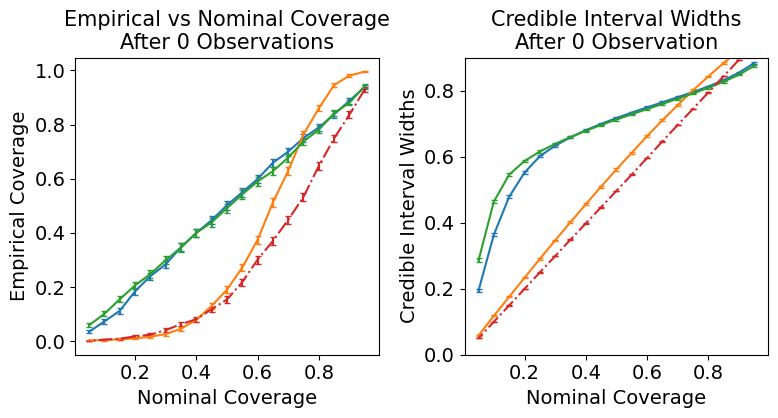

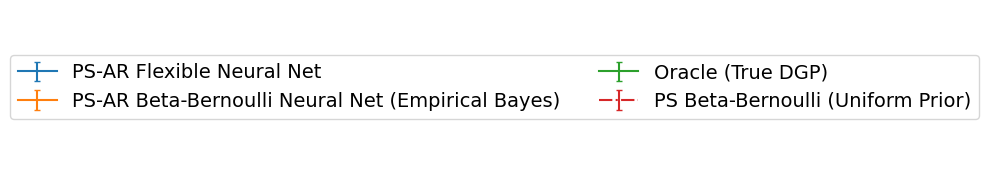

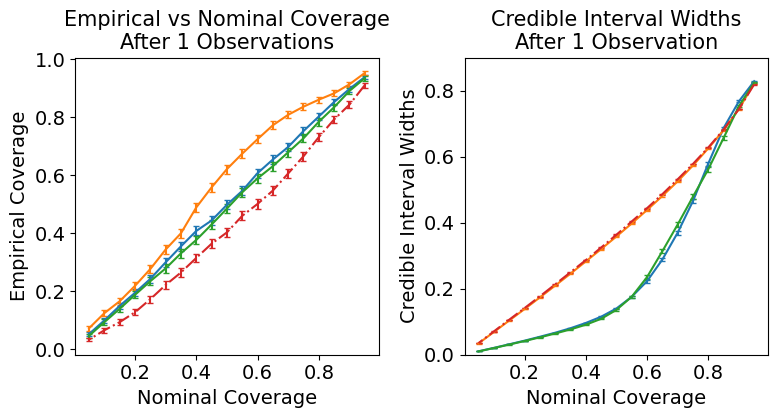

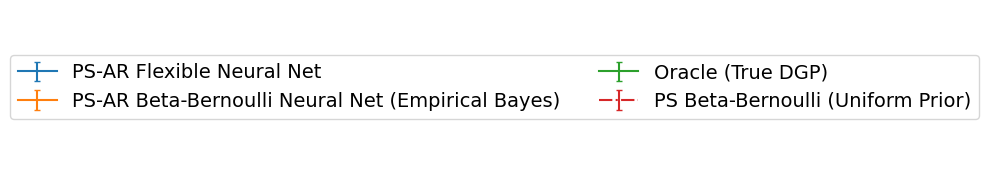

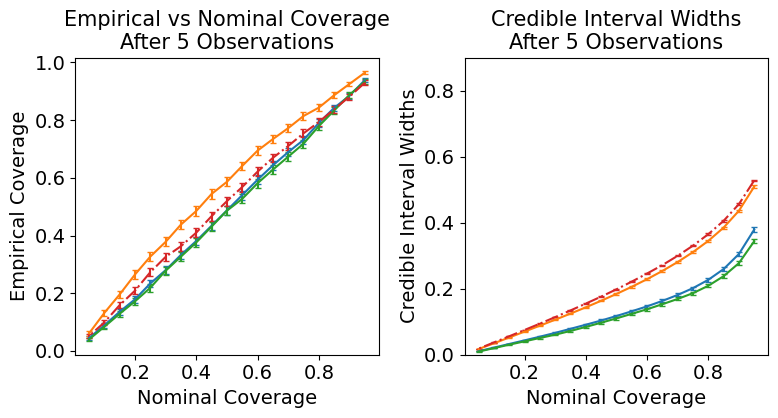

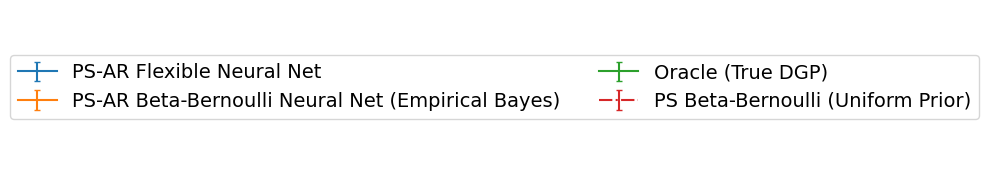

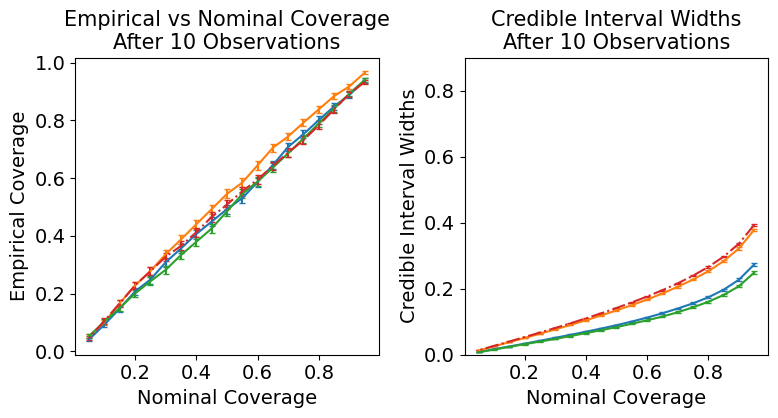

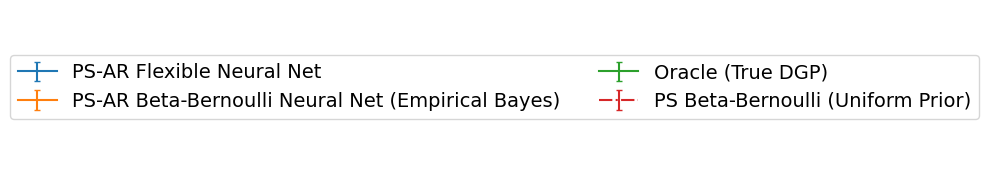

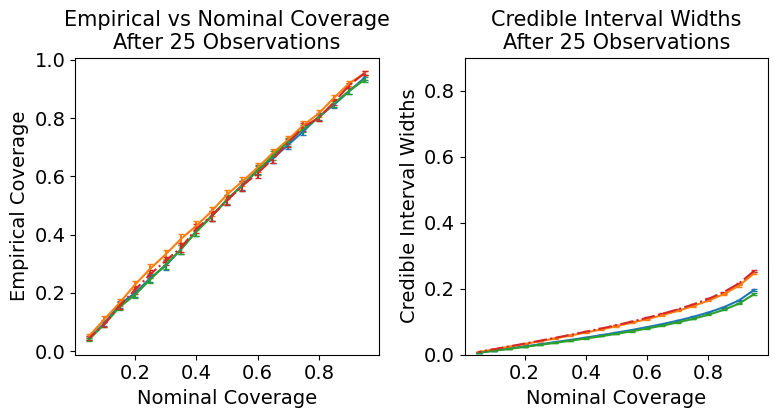

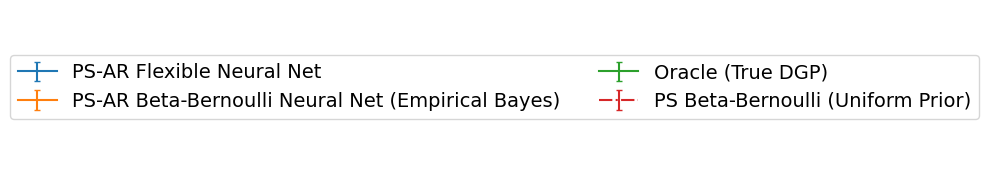

In [55]:
from util import make_plots_good
make_plots_good()
import pandas as pd
figsize=(8,4.4)
credible_interval_df = pd.DataFrame(credible_interval_dict)
df_tmp = pd.DataFrame(credible_interval_dict)
#all_num_prev_obs = [0] 
model_names = np.unique(df_tmp.model)


model_names = ['PS AutoReg Neural Net', 
               'PS AutoReg Beta-Bernoulli', 
               'Oracle (True DGP)',
               'Uniform Prior',
              ]

name_dict = {k:k for k in model_names}
name_dict['PS AutoReg Neural Net']='PS-AR Flexible Neural Net'
name_dict['Bimodal Beta-Bernoulli (Oracle (True DGP))']='PS Oracle'
name_dict['Uniform Prior']='PS Beta-Bernoulli (Uniform Prior)'
name_dict['PS AutoReg Beta-Bernoulli'] = 'PS-AR Beta-Bernoulli Neural Net (Empirical Bayes)'
linestyle = ['-', '-', '-', '-.','-.',':', ':', ':', '-.', '-.']

for i,num_obs in enumerate(all_num_prev_obs):
    fig,ax=plt.subplots(1,2,figsize=figsize)
    plt.tight_layout()
    fig.tight_layout()
    
    for j,model in enumerate(model_names):
#        print(model)
        df_tmp2 = df_tmp.loc[(df_tmp.num_prev_obs==num_obs)&(df_tmp.model==model)];
        dispname = name_dict[model]
        ax[0].errorbar(1-df_tmp2.sigval, df_tmp2.coverage, yerr=df_tmp2.coverage_stderr, 
                          capsize=2, label=dispname, linestyle=linestyle[j]);
    ax[0].set_title(f'Empirical vs Nominal Coverage\nAfter {num_obs} Observations', fontsize=15)
    ax[0].set_xlabel('Nominal Coverage')
    ax[0].set_ylabel('Empirical Coverage')

    for j,model in enumerate(model_names):
        df_tmp2 = df_tmp.loc[(df_tmp.num_prev_obs==num_obs)&(df_tmp.model==model)]
        dispname = name_dict[model]
        ax[1].errorbar(1-df_tmp2.sigval, df_tmp2.width, yerr=df_tmp2.width_stderr, 
                          capsize=2, label=dispname, linestyle=linestyle[j])#, linestyle=":");
    if num_obs > 1:
        ax[1].set_title(f'Credible Interval Widths\nAfter {num_obs} Observations', fontsize=15)
    else:
        ax[1].set_title(f'Credible Interval Widths\nAfter {num_obs} Observation', fontsize=15)
    ax[1].set_xlabel('Nominal Coverage')
    ax[1].set_ylabel('Credible Interval Widths')
    ax[1].set_ylim([0,0.9])
    plt.tight_layout()
    fig.tight_layout()


    label_params = ax[0].get_legend_handles_labels()

    figl, axl = plt.subplots(figsize=(6,2))
    axl.axis(False)
    axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5), ncol=2)
    